In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torchvision.ops as ops
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import json

C:\Users\getto\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = self._get_valid_image_ids()
        
    def _get_valid_image_ids(self):
        # Get image IDs with valid annotations
        valid_ids = []
        for img_id in self.coco.imgs.keys():
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                valid_ids.append(img_id)
        return valid_ids

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        
        if len(coco_annotation) == 0:
            # Skip images with no annotations
            return self.__getitem__((index + 1) % len(self.ids))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = []
        # Some objects are almost invisible in images, so we need to remove them from labels
        for i in range(num_objs):
            label = coco_annotation[i]['category_id']
            labels.append(label)
            
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [3]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.112, 0.112, 0.113], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [4]:
def image_shower(images, labels, n=1):
    for i, image in enumerate(images[:n]):
        fig, ax = plt.subplots(1)
        plt.subplot(n, n, i + 1)
        ax.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print(labels[0]['image_id'])
    for box in labels[0]["boxes"]:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        print(box)
    
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
    
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
        # Add rectangle patch to axes
        ax.add_patch(rect)
    ax.set_aspect('equal')
    plt.show()
    print("Real Labels: ", ' '.join('%5s' % classes[label.item()] for label in labels[0]["labels"]))

In [5]:
train_data_dir = './furniture.v3i.coco/train'
train_coco = './furniture.v3i.coco/train/_annotations.coco.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 10

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


tensor([1547])
tensor([  0.,   0., 628., 640.])


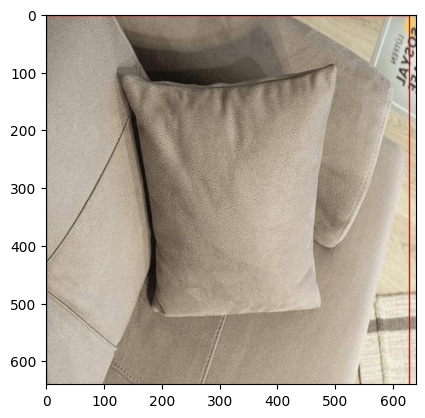

Real Labels:  couch


In [6]:
classes = {1:'bed', 2: 'chair', 3:'couch', 4:'table'}
images, labels = next(iter(data_loader))
image_shower(images, labels)

In [7]:
def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.

    Parameters:
    - box1 (list or numpy array): [x_min, y_min, x_max, y_max]
    - box2 (list or numpy array): [x_min, y_min, x_max, y_max]

    Returns:
    - IoU (float): Intersection over Union ratio.
    """
    if not isinstance(box1, (list, np.ndarray)) or not isinstance(box2, (list, np.ndarray)):
        raise ValueError("Input boxes must be lists or numpy arrays.")

    x_min_i = max(box1[0], box2[0])
    y_min_i = max(box1[1], box2[1])
    x_max_i = min(box1[2], box2[2])
    y_max_i = min(box1[3], box2[3])

    intersection_area = max(0, x_max_i - x_min_i) * max(0, y_max_i - y_min_i)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0

    return iou

In [8]:
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from tqdm import tqdm as tqdm_notebook

def evaluate(model, data_loader, device, iou_threshold=0.5, nms_threshold=0.1, confidence_threshold=0.5):
    model.eval()
    all_predictions = []
    all_targets = []
    all_iou_per_box = []

    with torch.no_grad():
        for imgs, annotations in tqdm_notebook(data_loader, desc='Validation'):
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

            predictions = model(imgs)
            all_predictions.extend(predictions)
            all_targets.extend(annotations)

    # Extract bounding boxes, labels, and scores from predictions and targets
    pred_boxes = [pred['boxes'].cpu().numpy() for pred in all_predictions]
    pred_labels = [pred['labels'].cpu().numpy() for pred in all_predictions]
    pred_scores = [pred['scores'].cpu().numpy() for pred in all_predictions]

    true_boxes = [target['boxes'].cpu().numpy() for target in all_targets]
    true_labels = [target['labels'].cpu().numpy() for target in all_targets]

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    all_iou_per_box = []

    # Matching strategy based on IoU
    for i in range(len(pred_boxes)):
        # Apply NMS to filter out redundant predictions
        keep = ops.nms(torch.tensor(pred_boxes[i]), torch.tensor(pred_scores[i]), iou_threshold=nms_threshold)
        pred_boxes[i] = pred_boxes[i][keep]
        pred_labels[i] = pred_labels[i][keep]
        pred_scores[i] = pred_scores[i][keep]
        
        if pred_boxes[i].ndim == 2:
            pass
        else:
            pred_boxes[i] = np.array([pred_boxes[i]])
            pred_labels[i] = np.array([pred_labels[i]])
            pred_scores[i] = np.array([pred_scores[i]])
        

        for j in range(len(pred_boxes[i])):
            if pred_scores[i][j] < confidence_threshold:
                continue
            ious = [calculate_iou(pred_boxes[i][j], true_box) for true_box in true_boxes[i]]
            max_iou = max(ious, default=0.0)

            # Check if the maximum IoU is above the threshold
            if max_iou >= iou_threshold:
                true_label = true_labels[i][ious.index(max_iou)]
                predicted_label = pred_labels[i][j]
                all_iou_per_box.append(max_iou)

                # Your logic for handling true positives, false positives, etc.
                if true_label == predicted_label:
                    true_positives += 1
                else:
                    false_positives += 1

                # Remove matched ground truth to avoid double counting
                matched_index = ious.index(max_iou)
                true_boxes[i] = np.delete(true_boxes[i], matched_index, axis=0)
            else:
                false_positives += 1

    # Count unmatched ground truth boxes as false negatives
    for i in range(len(true_boxes)):
        false_negatives += len(true_boxes[i])

    # Calculate accuracy and F1 score based on your logic for true positives, false positives, false negatives, etc.
    total_positives = true_positives + false_negatives
    total_predictions = true_positives + false_positives

    accuracy = true_positives / (true_positives + false_positives + false_negatives) if total_predictions > 0 else 0.0
    precision = true_positives / (true_positives + false_positives) if total_predictions > 0 else 0.0
    recall = true_positives / total_positives if total_positives > 0 else 0.0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    print(f'TP: {true_positives:.4f}, FP: {false_positives:.4f}, FN: {false_negatives:.4f}')
    print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Average IoU: {np.mean(all_iou_per_box):.4f}')
    return (accuracy, recall, f1, np.mean(all_iou_per_box))

In [9]:
torch.cuda.empty_cache()

In [10]:
valid_data_dir = './furniture.v3i.coco/valid'
valid_coco = './furniture.v3i.coco/valid/_annotations.coco.json'

# create own Dataset
validation_dataset = myOwnDataset(root=valid_data_dir,
                          annotation=valid_coco,
                          transforms=get_transform()
                          )

# Create a DataLoader for validation dataset
validation_data_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [11]:
import mlflow
import mlflow.pytorch

In [12]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("furniture")

<Experiment: artifact_location='file:///C:/Users/getto/mlruns/1', creation_time=1705676866635, experiment_id='1', last_update_time=1705676866635, lifecycle_stage='active', name='furniture', tags={}>

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# there are 4 types of furniture + background
num_classes = 5
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

with mlflow.start_run(run_name='5th_model'):
    model_params = {
        "momentum": 0.9,
        "lr": 0.005,
        "weight_decay": 0.0005,
        "train_batch_size": 10,
        "num_epochs": 1
    }

    # own DataLoader
    data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=model_params["train_batch_size"],
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

    # parameters
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=model_params["lr"], momentum=model_params["momentum"],
                                weight_decay=model_params["weight_decay"])
    
    len_dataloader = len(data_loader)

    num_epochs = model_params["num_epochs"]
    
    for epoch in range(num_epochs):
        model.train()
        i = 0    
        for imgs, annotations in data_loader:
            
            i += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            
        
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())
    
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    
            print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
    
    accuracy, recall, f1, average_iou = evaluate(model, validation_data_loader, device, iou_threshold=0.5, nms_threshold=0.1, confidence_threshold=0.6)

    metrics = {
        "accuracy": accuracy,
        "recall": recall,
        "f1": f1,
        "average_iou": average_iou
    }
    # Log parameters
    mlflow.log_params(model_params)

    # Log model
    mlflow.pytorch.log_model(model, 'model5')

    # Log metrics
    mlflow.log_metrics(metrics)

C:\Users\getto\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\getto\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iteration: 1/262, Loss: 1.9899065494537354
Iteration: 2/262, Loss: 0.7882552742958069
Iteration: 3/262, Loss: 0.33500421047210693
Iteration: 4/262, Loss: 0.37318629026412964
Iteration: 5/262, Loss: 0.4413285553455353
Iteration: 6/262, Loss: 0.552582323551178
Iteration: 7/262, Loss: 0.4744762182235718
Iteration: 8/262, Loss: 0.44719094038009644
Iteration: 9/262, Loss: 0.33201006054878235
Iteration: 10/262, Loss: 0.3136325776576996
Iteration: 11/262, Loss: 0.2563793361186981
Iteration: 12/262, Loss: 0.2580876052379608
Iteration: 13/262, Loss: 0.2839503884315491
Iteration: 14/262, Loss: 0.20321319997310638
Iteration: 15/262, Loss: 0.2256898283958435
Iteration: 16/262, Loss: 0.25469791889190674
Iteration: 17/262, Loss: 0.20885753631591797
Iteration: 18/262, Loss: 0.21522822976112366
Iteration: 19/262, Loss: 0.23464490473270416
Iteration: 20/262, Loss: 0.23303838074207306
Iteration: 21/262, Loss: 0.32618245482444763
Iteration: 22/262, Loss: 0.19550976157188416
Iteration: 23/262, Loss: 0.258

Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [01:47<00:00,  2.68s/it]


TP: 356.0000, FP: 62.0000, FN: 82.0000
Accuracy: 0.7120, Recall: 0.8128, F1 Score: 0.8318
Average IoU: 0.8421


2024/01/24 16:58:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/01/24 16:58:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.16.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [92]:
# Save the model and optimizer state
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_epochs': num_epochs,
}

# Choose a filename for your checkpoint
checkpoint_filename = 'my_model_checkpoint2.pth'

# Save the checkpoint
torch.save(checkpoint, checkpoint_filename)

In [11]:
# Load the checkpoint
checkpoint = torch.load('my_model_checkpoint.pth')

# Create a new instance of your model
model = get_model_instance_segmentation(num_classes)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create a new instance of your optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Load the optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Additional variables (if any)
num_epochs = checkpoint['num_epochs']

In [48]:
accuracy, recall, f1, average_iou = evaluate(model, validation_data_loader, device, iou_threshold=0.5, nms_threshold=0.07, confidence_threshold=0.6)

Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [03:47<00:00,  5.68s/it]

TP: 388.0000, FP: 33.0000, FN: 62.0000
Accuracy: 0.8033, Recall: 0.8622, F1 Score: 0.8909
Average IoU: 0.8560


In [19]:
def get_transform_test():
    custom_transforms = []
    #custom_transforms.append(torchvision.transforms.Resize((640, 640)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.162, 0.162, 0.163], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [20]:
random_image_path = "living.png"
img = Image.open(random_image_path).convert("RGB")
transform = get_transform_test()
img = transform(img)
img = img.unsqueeze(0)  # Add a batch dimension

In [21]:
img = img.to(device)
with torch.no_grad():
    predictions = model(img)

In [22]:
boxes = predictions[0]["boxes"].cpu().numpy()
labels = predictions[0]["labels"].cpu().numpy()
scores = predictions[0]["scores"].cpu().numpy()

# Apply non-maximum suppression (NMS) to filter the bounding box predictions
keep = ops.nms(torch.from_numpy(boxes), torch.from_numpy(scores), iou_threshold = 0.1)

# Filter the bounding boxes, labels, and scores using the NMS results
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]

[441.79562 287.971   828.25696 486.70294]
[400.2712  274.20813 480.41525 333.06992]
[103.560745 269.0321   297.1627   483.9188  ]
[484.26965 276.9166  551.52136 327.07877]
[754.579   238.28365 904.7277  348.3803 ]
[290.9153  324.71564 384.6552  444.9383 ]
[562.3651  279.52606 634.4725  338.38696]


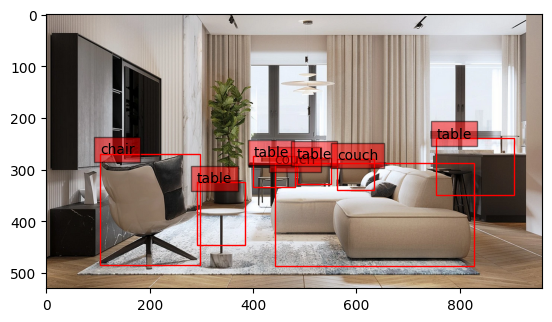

In [23]:

# Convert image tensor to numpy array
image = img.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image)


if isinstance(labels, np.int64):
    label = labels
    labels = []
    labels.append(label)
    box = boxes
    boxes = []
    boxes.append(box)

# Iterate over bounding boxes and labels
for box, label in zip(boxes, labels):
    # Extract coordinates
    x_min, y_min, x_max, y_max = box
    print(box)
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add rectangle patch to axes
    ax.add_patch(rect)
    
    # Add label text to axes
    ax.text(x_min, y_min, f"{classes[label]}", bbox=dict(facecolor='r', alpha=0.5))

# Set aspect ratio and show plot
ax.set_aspect('equal')
plt.show()

In [66]:
import random

def visualize_prediction(model, data_loader, device, num_images=1, iou_threshold=0.5, confidence_threshold=0.5):
    model.eval()

    classes = {1:'bed', 2: 'chair', 3:'couch', 4:'table'}
    # Get a batch of random images from the validation dataset
    random_images, random_annotations = zip(*random.sample(list(data_loader.dataset), num_images))
    random_images = [img.to(device) for img in random_images]

    with torch.no_grad():
        predictions = model(random_images)

    # Visualize the predictions
    for i in range(num_images):
        img = random_images[i].cpu().numpy().transpose((1, 2, 0))
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Apply NMS and confidence score filtering
        keep = ops.nms(predictions[i]['boxes'], predictions[i]['scores'], iou_threshold)
        filtered_boxes = predictions[i]['boxes'][keep]
        filtered_scores = predictions[i]['scores'][keep]
        filtered_labels = predictions[i]['labels'][keep]

        # Plot ground truth bounding boxes
        for box in random_annotations[i]['boxes']:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Plot predicted bounding boxes after filtering
        for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
            if score >= confidence_threshold:
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'{classes[label.item()]} {score:.2f}', fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))

        plt.show()

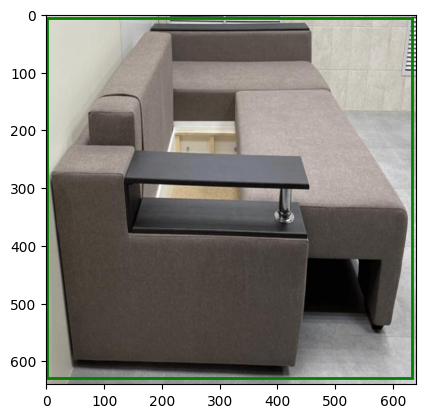

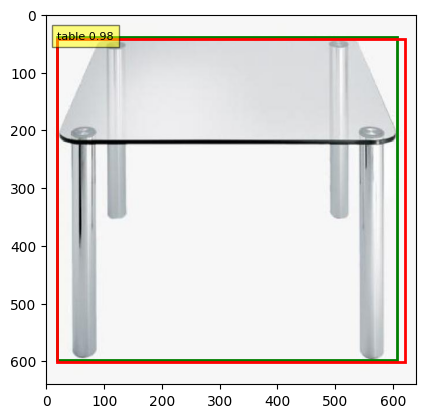

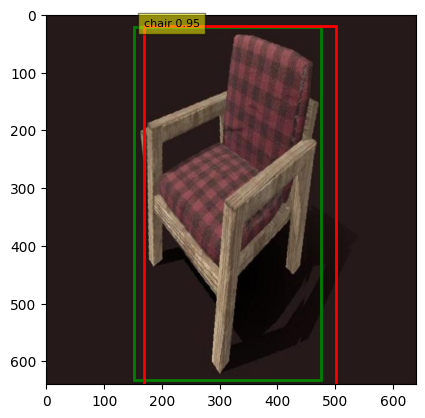

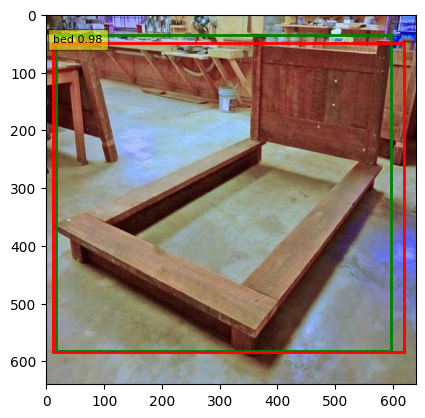

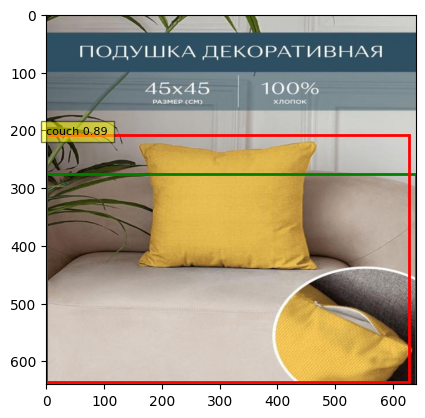

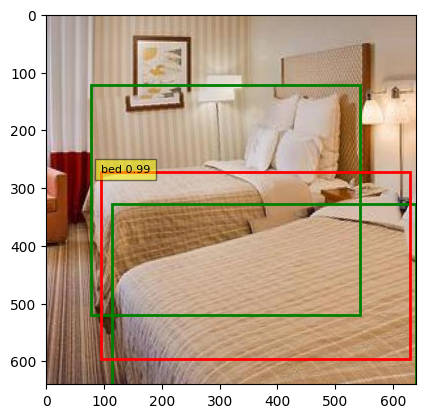

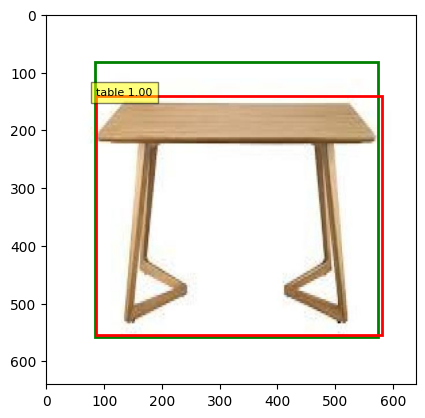

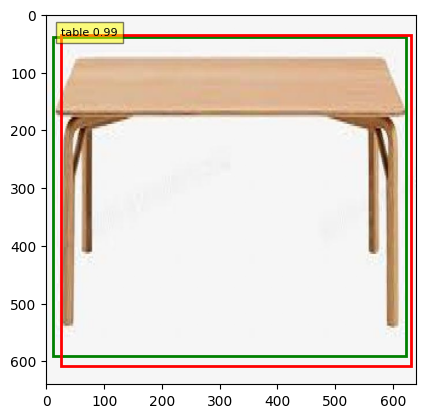

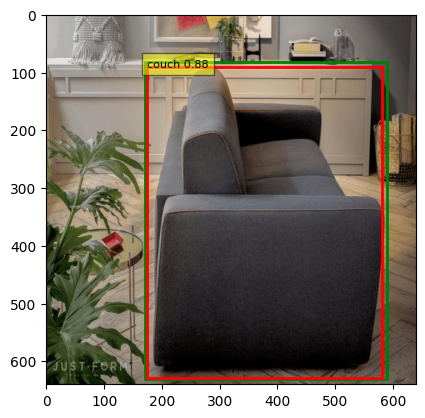

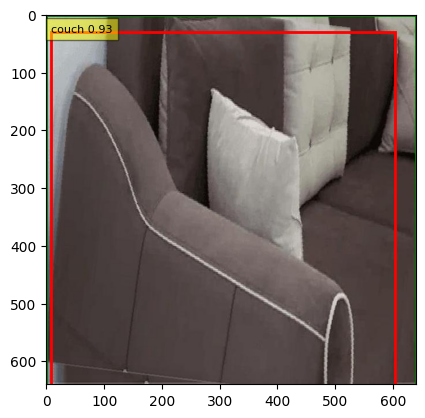

In [68]:
visualize_prediction(model, data_loader, device, num_images=10, iou_threshold=0.07, confidence_threshold=0.8)